In [35]:
import os
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np

In [36]:
host = 'slucor2022-instance-1.cgdcoitnku0k.us-east-1.rds.amazonaws.com'
port = '3306'
user = 'slucor2022'
password = 'SLUcor2022'
database = 'hds5210'

In [37]:
conn = create_engine('mysql+pymysql://' + 
                     user + ':' + 
                     password + '@' + 
                     host + '/' + 
                     database, echo=False)

In [38]:
import getpass
myname = getpass.getuser().split('-')[1]
myname
MYTABLE = myname + '_data' + '_final'

conn.connect()

### Loading all the necessary data:: Data Sources : Local files, SQL. Data Formats: CSV, JSON, Excel

In [39]:
life_expectancy_till_2010 = pd.read_csv("Life expectancy Data till 2010.csv")
json_data = pd.read_json("Life expectancy Data from 2010.json")
schooling_data = pd.read_excel("schooling_data.xlsx")
json_data.to_sql(MYTABLE, conn, if_exists = 'replace', index = False)
sql_data_df = pd.read_sql_query('SELECT * FROM ' + MYTABLE, conn)

### This function merges the given dataframes and returns the merged data frame. Input: Two dataframes which need to be merged.

In [40]:
def append_data_return_df(df1, df2):
    merged_data = []
    merged_data.append(df1)
    merged_data.append(df2)
    merged_df = pd.concat(merged_data)
    return merged_df

#### In the below cell we get the merged dataFrame from local file and sql 

In [41]:
data = append_data_return_df(life_expectancy_till_2010, sql_data_df)

### Checking whether Life expectancy column has Nan values.

In [42]:
any(data['Life expectancy'].isna())

True

### Dropping the missing values in Life expectancy column instead of using the mean values because there might be irregularities due to different years and countries being present.  

In [43]:
data = data.dropna(subset=['Life expectancy'])

### Making sure we are not left with any Nan values in Life expectancy column. 

In [44]:
any(data['Life expectancy'].isna())

False

### The below function accepts a dataframe, parameters to pivot that dataframe(index, values and aggfunc). We then pivot the table and showcase the pivoted table and return it after resetting the index.

In [45]:
def pivot_print_data_reset(df, index, values, aggfunc):
  pivot_df = df.pivot_table(index = index, values = values, aggfunc = aggfunc)
  print(pivot_df)
  reset_df = pivot_df.reset_index()
  return reset_df

### The below outcome explains that there is a significant difference in Life expectancy with respect to the status of the country. One way to think is, how can we make the country developed such that it in-turn raises the life expectancy value.

In [46]:
by_status_fun = pivot_print_data_reset(data, 'Status', 'Life expectancy', 'mean')

            Life expectancy
Status                     
Developed         79.197852
Developing        67.111465


### The below function plots the histogram for you based on your dataFrame, column Keys and column Values. We create the dictionary and map the values accordingly and call the inbuilt bar graph function.

In [47]:
def hist_based_on_status(df, column_key, column_value):
  import matplotlib.pyplot as plt
  store = dict()
  for i in df.index: store[df[column_key][i]] = df[column_value][i]
  plt.bar(store.keys(), store.values())
  plt.show()

### Visualization of the life expectancy vs the status of the country.

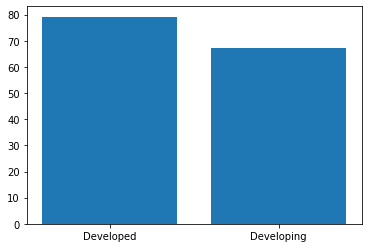

In [48]:
hist_based_on_status(by_status_fun, 'Status', 'Life expectancy')

### Irrespective of the year, now if we want to know the average of the life Expectancy for every country. And in the upcoming cells, let's see how this pivoting will help us reach our final destination

In [49]:
by_country_fun = pivot_print_data_reset(data, 'Country', 'Life expectancy', 'mean')

                                    Life expectancy
Country                                            
Afghanistan                                58.19375
Albania                                    75.15625
Algeria                                    73.61875
Angola                                     49.01875
Antigua and Barbuda                        75.05625
...                                             ...
Venezuela (Bolivarian Republic of)         73.38750
Viet Nam                                   74.77500
Yemen                                      63.86250
Zambia                                     53.90625
Zimbabwe                                   50.48750

[183 rows x 1 columns]


### Sorting the data frame with respect to Life expectancy percentage to understand which countries did the best from 2000 to 2015 and the lower ones need to be monitored by WHO or require funding and caring to increase the life expectancy.

In [50]:
by_country_fun_sorted = by_country_fun.sort_values('Life expectancy') 

### These are the top 5 Countries which need more monitoring, funding and caring. These are the countries which are bringing down the worlds's average life expectancy. And they are in need to be monitored and understand what exactly is the main reason behind the low life expectancy. 

In [51]:
by_country_fun_sorted.head()

,Country,Life expectancy
143,Sierra Leone,46.11250
31,Central African Republic,48.51250
92,Lesotho,48.78125
3,Angola,49.01875
98,Malawi,49.89375


In [52]:
by_country_fun_sorted.tail()

,Country,Life expectancy
58,France,82.21875
157,Switzerland,82.33125
73,Iceland,82.44375
156,Sweden,82.51875
82,Japan,82.53750


### Replacing missing values in Hepatitis B with the mean, at last let's see how much does Life expectancy depend on Hepatitis B

In [53]:
print(any(data['Hepatitis B'].isna()))
data['Hepatitis B'].fillna(int(data['Hepatitis B'].mean()), inplace=True)
any(data['Hepatitis B'].isna())

True


False

### This scatter plot points out each country's life expectancy average from 2001-2015. it is to verify whether the Countries are sorted according to their Life expectancy.

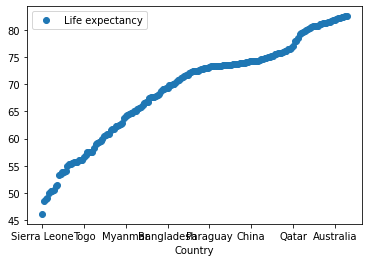

In [54]:
by_country_fun_sorted.plot(x='Country', y='Life expectancy', style='o')

### World average life expectancy per year

#### World's avergae Life expectancy has increased around 5% from 2000 to 2015. Almost every year it got a gradual increase from its previous year, which is a good sign for the world. 

In [55]:
any(data['Year'].isna())

False

In [56]:
by_year_fun = pivot_print_data_reset(data, 'Year', 'Life expectancy', 'mean')

      Life expectancy
Year                 
2000        66.750273
2001        67.128962
2002        67.351366
2003        67.433333
2004        67.646448
2005        68.209290
2006        68.667760
2007        69.036066
2008        69.427869
2009        69.938251
2010        70.048634
2011        70.654098
2012        70.916940
2013        71.236066
2014        71.536612
2015        71.616940


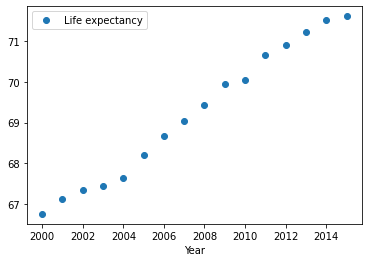

In [57]:
by_year_fun.plot(x='Year', y='Life expectancy', style='o')

### groupby_fields function returns a grouped dataFrame which is grouped on given columns and the columns to output based on the required_columns parameter, and we aggregate on the inbuilt sum function and then return it after resetting the index.

In [58]:
def groupby_fields(df, groupby_columns, required_columns):
    grouped_df = df.groupby(groupby_columns)[required_columns].sum().reset_index()
    return grouped_df

### The below function returns the new dataframe created based on the columns and conditions given in input parameters. This needs to be extended for addition, subtraction and multiplcation too.

In [59]:
def derive_under_five_death_percent(df, new_column, first_column, second_column, operator):
  if operator == 'division':
    derived_df = df[df[second_column] != 0.0] #As we are gonna divide it in the next step, so ensuring that no cell has zero value.
    derived_df[new_column] = derived_df[first_column] / derived_df[second_column]
  return derived_df

### This helps us in knowing which country needs more funds and care with respect to the new born babies and we can investigate whether these deaths are due to not having good facilities in hospital for a new born baby or are they born with some disease.

In [60]:
groupby_country_df = groupby_fields(data, ['Country'], ['under-five deaths', 'Population'])
by_country_under_five_deaths_percent = derive_under_five_death_percent(groupby_country_df, 'under_five_death_percent', 'under-five deaths', 'Population', 'division').sort_values('under_five_death_percent')
by_country_under_five_deaths_percent['under_five_death_percent'] = by_country_under_five_deaths_percent['under_five_death_percent'] * 100 
by_country_under_five_deaths_percent_non_zero = by_country_under_five_deaths_percent[by_country_under_five_deaths_percent.under_five_death_percent != 0.000000]
by_country_under_five_deaths_percent_non_zero.sort_values('under_five_death_percent')

/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Country,under-five deaths,Population,under_five_death_percent
151,Spain,30,424685666.0,0.000007
80,Italy,37,442300623.0,0.000008
62,Germany,52,620117559.0,0.000008
114,Netherlands,16,156411270.0,0.000010
58,France,55,441307730.0,0.000012
...,...,...,...,...
79,Israel,16,445806.0,0.003589
82,Japan,64,1558145.0,0.004107
61,Georgia,20,162438.0,0.012312
152,Sri Lanka,76,173517.0,0.043800


### We utilize the schooling data read from schooling_data.xlsx and also the data and this file cannot be directly paired, we group by with respect to their country and inner join them both by aggreagating with the mean Life expectancy of every country and display it such that we can the relevance w.r.t schooling and life expectancy

In [61]:
schooling_data_grouped = schooling_data.groupby(['Country'])['Schooling'].mean().reset_index()
sub_data = data[['Country', 'Life expectancy']]
sub_data = sub_data.groupby(['Country'])['Life expectancy'].mean().reset_index() 
joined_school_data = sub_data.merge(schooling_data_grouped, how='inner')
joined_school_data

,Country,Life expectancy,Schooling
0,Afghanistan,58.19375,8.21250
1,Albania,75.15625,12.13750
2,Algeria,73.61875,12.71250
3,Angola,49.01875,8.04375
4,Antigua and Barbuda,75.05625,8.84375
...,...,...,...
177,Venezuela (Bolivarian Republic of),73.38750,12.78750
178,Viet Nam,74.77500,11.51250
179,Yemen,63.86250,8.50625
180,Zambia,53.90625,11.21250


### To check whether life expectancy has some positive/negative correlation or dependency on alcohol drinking people percentage and percentage of people who completed schooling and also the BMI.

#### Below is a straight-forward pivot and plot functions, this function takes the neccesary parameters to pivot the table and then it plots based on pivoted data.

In [62]:
def pivot_and_plot(df, index, values, aggfunc):
  pivoted_data = df.pivot_table(index = index, values = values, aggfunc = aggfunc)
  pivoted_data.plot()

#### We could observe that there is lot of randomness in alcohol vs life expectancy graph but, schooling and BMI are almost directly proportional to the life expectancy

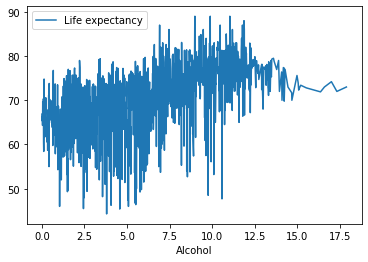

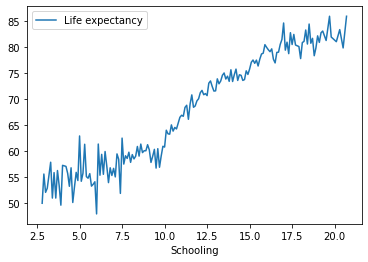

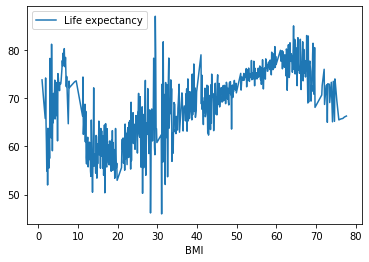

In [63]:
pivot_and_plot(data, 'Alcohol', 'Life expectancy', 'mean')
pivot_and_plot(data[data.Schooling > 0], 'Schooling', 'Life expectancy', 'mean')
pivot_and_plot(data, 'BMI', 'Life expectancy', 'mean')

## We can't go through the whole dataframe each time and search for our country name and then check each year's life expectancy. Main idea is to group the data based on the country and year. Then, we give the user to choose the country and return the data for each year with respect to that country and along with a scatter plot indicating how was the life expectancy changing through all those years.

#### This is a utility function to filter out the country and visualize the life expectancy fot that country over the years. This function accepts the dataframe and the country name entered by the user

In [64]:
def country_year(df, country):
  df = df[df.Country == country]  # Filter based on the user given country
  df.plot(x='Year', y='Life expectancy', style='o') # plot based on the filtered data
  return df

In [65]:
by_country_year = data.groupby(['Country', 'Year'])['Life expectancy'].mean().reset_index()

,Country,Year,Life expectancy
0,Afghanistan,2000,54.8
1,Afghanistan,2001,55.3
2,Afghanistan,2002,56.2
3,Afghanistan,2003,56.7
4,Afghanistan,2004,57.0
5,Afghanistan,2005,57.3
6,Afghanistan,2006,57.3
7,Afghanistan,2007,57.5
8,Afghanistan,2008,58.1
9,Afghanistan,2009,58.6


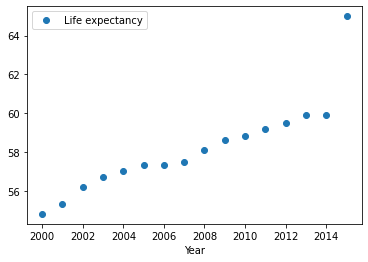

In [66]:
country_year(by_country_year, 'Afghanistan')

#### User can enter one of the country name and the data with respect to that country for all years displayed and then a small visualization.

,Country,Year,Life expectancy


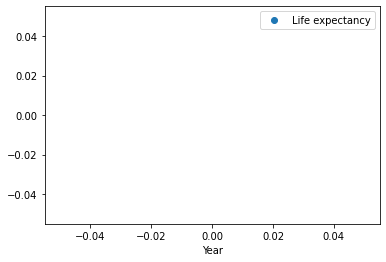

In [68]:
country = input()
country_year(by_country_year, country)

## Usage of whatever done till now.

#### To find out what are the various predicting factors which has been choosen initially affect the Life expectancy? What are the predicting variables actually affecting the life expectancy?

#### Which countries need to increase its healthcare expenditure in order to improve its average lifespan?

#### Does life expectancy has correlation with respect to BMI, Hepatitis B, HIV, drinking alcohol etc.

#### The impact of schooling on the lifespan of humans?

#### Where are under five year babies deaths most in number, this helps us to increase the care or funding in those countries.

In [70]:
a=input('''
Are you ready to submit your work?
1. Click the Save icon (or do Ctrl-S / Cmd-S)
2. Type "yes" or "no" below
3. Press Enter

''')

if a=='yes':
    !git add final.ipynb
    !git commit -a -m "Submitting the Sahitya_HDS_Final.ipynb"
    !git push
else:
    print('''
    
OK. We can wait.
''')


Are you ready to submit your work?
1. Click the Save icon (or do Ctrl-S / Cmd-S)
2. Type "yes" or "no" below
3. Press Enter

 yes


fatal: pathspec 'final.ipynb' did not match any files
On branch main
Your branch is up to date with 'origin/main'.

Untracked files:
	../EHR.csv
	../HospInfo.csv
	../Untitled.ipynb
	../Untitled1.ipynb
	../apache_patients.csv
	./
	../week 03/week03_class.ipynb
	../week 04/week04_examples.ipynb
	../week 04/week04_lookups.ipynb
	../week 05/
	../week 06/module29-xml-examples.ipynb
	../week 06/week06_inclass_1.ipynb
	../week 10/Number_of_Cancer_Cases_for_All_Cancer_Sites_by_Jurisdiction__Gender__and_Race__Maryland_2009.csv
	../week 13/HospInfo.csv
	../week02/

nothing added to commit but untracked files present
Everything up-to-date
